## Setup

In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import time
import re
import tensorflow as tf
import tensorflow_hub as hub
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import string
import sys
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed
from datetime import datetime

%matplotlib inline

#set working directory
#os.chdir("/Users/alexdessouky/Desktop/MIDS/w266")

In [9]:
#load training data
twitter_train = pd.read_excel('./StanceDataset/train.xlsx')
train_x = twitter_train['Tweet']
train_y = twitter_train[['Stance','Target']]


#load test data
twitter_test = pd.read_excel('./StanceDataset/test.xlsx')
test_x = twitter_test['Tweet']
test_y = twitter_test[['Stance','Target']]

# Carve out 15% of train data to use as dev data
train_x, dev_x, train_y, dev_y = train_test_split(train_x, train_y, test_size=0.15, random_state=42)

# Need to save the target arrays for test & dev separately; then can drop them from our y arrays
train_target = train_y['Target']
test_target = test_y['Target']
dev_target = dev_y['Target']

train_y = train_y['Stance']
test_y = test_y['Stance']
dev_y = dev_y['Stance']

In [10]:
#store the paths to bert & data
bert_path =   '/Users/alexdessouky/Desktop/MIDS/w266/bert' 
#bert_path = r'/home/timspittle/w266_final_project/bert/' 


now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,bert_path)

In [11]:
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

# Tensorflow hub path to BERT module
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

# Define maximal length of input 'sentences' (post tokenization).
max_length = 83 ## max length with no preprocessing

## Bert tokenizer

In [12]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

## If we want to "Clean" the tweets; uncomment out this cell (performs better without)

In [13]:
#def preprocess_tweets(x):
    
    # Remove punctuation EXCEPT for hashtags (#) and handles (@)
#    exclude_punc = [punc for punc in string.punctuation if punc not in ['#', '@']]
#    x_nopunc = ''.join(ch for ch in x if ch not in exclude_punc)

    # lower case
#    x_lower = x_nopunc.lower()
    
    # Replace digits with DIGIT
#    x_digits = re.sub("\d+", "DIGIT", x_lower)
    
#    return x_digits

#train_x = twitter_train['Tweet'].apply(lambda x: preprocess_tweets(x))
#test_x = twitter_test['Tweet'].apply(lambda x: preprocess_tweets(x))

#max_length = 95 #redefine max length - this is what it is when we clean the tweets

## Create Inputs for BERT

In [14]:
#create tokens surrounded by the [CLS] and [SEP] tokens
train_tokens = train_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
test_tokens = test_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
dev_tokens = dev_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])

#mask ids (mask out the paddings)
train_mask_ids = train_tokens.apply(lambda x: len(x)*[1])
test_mask_ids = test_tokens.apply(lambda x: len(x)*[1])
dev_mask_ids = dev_tokens.apply(lambda x: len(x)*[1])

train_mask_ids = train_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                      np.array(x)).tolist()
test_mask_ids = test_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                    np.array(x)).tolist()
dev_mask_ids = dev_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                    np.array(x)).tolist()

#add padding to tokens
train_tokens = train_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)
test_tokens = test_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)
dev_tokens = dev_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)

#test/train sequence vectors
train_sequenceids = train_tokens.apply(lambda x: np.array(max_length*[0])).tolist()
test_sequenceids = test_tokens.apply(lambda x: np.array(max_length*[0])).tolist()
dev_sequenceids = dev_tokens.apply(lambda x: np.array(max_length*[0])).tolist()

#convert tokens to sentence ids
train_sentenceids = train_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()
test_sentenceids = test_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()
dev_sentenceids = dev_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()

#bert features
bert_train = [np.array(train_sentenceids),np.array(train_mask_ids),np.array(train_sequenceids)]
bert_test = [np.array(test_sentenceids),np.array(test_mask_ids),np.array(test_sequenceids)]
bert_dev = [np.array(dev_sentenceids),np.array(dev_mask_ids),np.array(dev_sequenceids)]

#labels
stance_labels_train = np.array(train_y.apply(lambda x: 
                                             2 if x == "FAVOR" else 
                                             (1 if x == "NONE" else 0)))

stance_labels_test = np.array(test_y.apply(lambda x: 
                                           2 if x == "FAVOR" else 
                                           (1 if x == "NONE" else 0)))

stance_labels_dev = np.array(dev_y.apply(lambda x: 
                                         2 if x == "FAVOR" else 
                                         (1 if x == "NONE" else 0)))
      

#PREP LABELS FOR NN
train_y = np.zeros(shape = (stance_labels_train.shape[0],3))
train_y[stance_labels_train == 0,0] = 1
train_y[stance_labels_train == 1,1] = 1
train_y[stance_labels_train == 2,2] = 1

test_y = np.zeros(shape = (stance_labels_test.shape[0],3))
test_y[stance_labels_test == 0,0] = 1
test_y[stance_labels_test == 1,1] = 1
test_y[stance_labels_test == 2,2] = 1

dev_y = np.zeros(shape = (stance_labels_dev.shape[0],3))
dev_y[stance_labels_dev == 0,0] = 1
dev_y[stance_labels_dev == 1,1] = 1
dev_y[stance_labels_dev == 2,2] = 1

## Check data shapes

In [15]:
print("Train (raw)")
print(len(twitter_train['Stance']))

print("Train (minus Dev)")
print(str(bert_train[0].shape) + str(bert_train[1].shape) + str(bert_train[2].shape))
print(train_y.shape)

print("Dev")
print(str(bert_dev[0].shape) + str(bert_dev[1].shape) + str(bert_dev[2].shape))
print(dev_y.shape)

print("Test")
print(str(bert_test[0].shape) + str(bert_test[1].shape) + str(bert_test[2].shape))
print(test_y.shape)

Train (raw)
2914
Train (minus Dev)
(2476, 83)(2476, 83)(2476, 83)
(2476, 3)
Dev
(438, 83)(438, 83)(438, 83)
(438, 3)
Test
(1956, 83)(1956, 83)(1956, 83)
(1956, 3)


## Function to obtain a subset of the data

In [19]:
def topic_subset(topic_list):
        
    #convert topic list to lower case
    for i in range(0,len(topic_list)):
        topic_list[i] = topic_list[i].lower()
    
    #Find boolean series of all rows pertaining to the relevant topics
    matches_train = train_target.apply(lambda x: x.lower() in topic_list)
    matches_dev = dev_target.apply(lambda x: x.lower() in topic_list)
    matches_test = test_target.apply(lambda x: x.lower() in topic_list)
    
    # Subset tweets
    train_x_sub = train_x[matches_train]
    dev_x_sub = dev_x[matches_dev]
    test_x_sub = test_x[matches_test]
    
    # Initialize bert training lists for subsetting
    train_bert_sub = []
    dev_bert_sub = []
    test_bert_sub = []
    
    for train_input in bert_train:
        train_bert_sub.append(train_input[matches_train,:])
    for dev_input in bert_dev:
        dev_bert_sub.append(dev_input[matches_dev,:])
    for test_input in bert_test:
        test_bert_sub.append(test_input[matches_test,:])
        
    # Subset labels
    train_y_sub = train_y[matches_train,:]
    dev_y_sub = dev_y[matches_dev,:]
    test_y_sub = test_y[matches_test,:]
    
    # Also need to return the labels in this format for metrics
    train_true_labels = stance_labels_train[matches_train]
    dev_true_labels = stance_labels_dev[matches_dev]
    test_true_labels = stance_labels_test[matches_test]
    
    return train_x_sub, train_bert_sub, train_y_sub, train_true_labels, \
            dev_x_sub, dev_bert_sub, dev_y_sub, dev_true_labels, \
            test_x_sub, test_bert_sub, test_y_sub, test_true_labels,

## Functions to Run Standard Metrics

In [15]:
def confusion_plot(confusion_matrix, target_names):
    
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.ylim([-0.5, 2.5]) # Fixed values for now
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
def metrics(true_labels, test_probs):
    
    #find predicted labels
    test_predicts = np.argmax(test_probs, axis = 1)
    
    #calculate f1 score and print classification report
    class_report = classification_report(y_true = true_labels, 
                                        y_pred = test_predicts,
                                        target_names = ['Against', 'None', 'Favor'], output_dict=True)
    
    print("F1 macro score (Favor and Against only)", str((class_report['Favor']['f1-score'] + 
         class_report['Against']['f1-score']) / 2))
    
    print(classification_report(y_true = true_labels, 
                                        y_pred = test_predicts,
                                        target_names = ['Against', 'None', 'Favor']))
    
    confuse = confusion_matrix(y_true = true_labels, y_pred = test_predicts)
    
    plt.figure(figsize=(15, 5))
    confusion_plot(confuse, ['Against', 'None', 'Favor'])
    plt.show()

## Custom layer for BERT Embeddings

In [16]:
class BertLayer_Seq(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer_Seq, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_url,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name and not "/pooler/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer_Seq, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "sequence_output"
        ]
        
        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
        
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

## Define Model

In [17]:
def bert_model_seq(max_length, train_layers, optimizer, dropout_rate):
    
    #inputs
    in_id = tf.keras.layers.Input(shape=(max_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), name="segment_ids")
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    #obtain bert Sequential output
    bert_sequence = BertLayer_Seq(n_fine_tune_layers=train_layers)(bert_inputs)
    
    #perform dropout
    dropout1= tf.keras.layers.Dropout(rate=dropout_rate)(bert_sequence)
    
    #LSTM layer to handle Sequential output
    lstm1 = tf.keras.layers.LSTM(128, name='lstm1')(dropout1)
    
    #Feed LSTM layer to 1 dense layer
    dense1 = tf.keras.layers.Dense(64, activation='relu', 
                                 kernel_initializer = tf.keras.initializers.he_normal(), 
                                 name='dense1')(lstm1)
    
    #perform another dropout
    dropout2 = tf.keras.layers.Dropout(rate=dropout_rate)(dense1)
    
    #classification layer
    pred = tf.keras.layers.Dense(3, activation='softmax', name='classification')(dropout2)
    
    #compile model
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['categorical_accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

## Run Models on each Target

## Atheism

In [67]:
#subset the data
train_tweets, train_data, train_y_array, train_y_labels, dev_tweets, dev_data, dev_y_array, dev_y_labels, test_tweets, test_data, test_y_array, test_y_labels = topic_subset(['Atheism'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(train_y_labels), train_y_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

#create model instance
model = bert_model_seq(max_length = max_length, 
                       train_layers = 6, 
                       optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                                            beta_1 = 0.9,
                                                            beta_2 = 0.999),
                       dropout_rate = 0.5)

# Instantiate variables
initialize_vars(sess)

#train model
model.fit(
    train_data, 
    train_y_array,
    validation_data = [dev_data, dev_y_array],
    epochs = 20,
    verbose = 1,
    batch_size = 32,
    class_weight = weights)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_4 (BertLayer_Se (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
425/425 [==============================] - 42s 98ms/sample - loss: 1.1445 - categorical_accuracy: 0.3882 - val_loss: 0.9769 - val_categorical_accuracy: 0.5455
Epoch 2/20
425/425 [==============================] - 33s 78ms/sample - loss: 0.9464 - categorical_accuracy: 0.5812 - val_loss: 0.7705 - val_categorical_accuracy: 0.5455
Epoch 3/20
425/425 [==============================] - 33s 78ms/sample - loss: 0.7768 - categorical_accuracy: 0.6729 - val_loss: 0.6185 - val_categorical_accuracy: 0.7614
Epoch 4/20
425/425 [==============================] - 33s 78ms/sample - loss: 0.5603 - categorical_accuracy: 0.7953 - val_loss: 0.5608 - val_categorical_accuracy: 0.8068
Epoch 5/20
425/425 [==============================] - 33s 77ms/sample - loss: 0.4215 - categorical_accuracy: 0.8612 - val_loss: 0.8348 - val_categorical_accuracy: 0.6818
Epoch 6/20
425/425 [==============================] - 32s 75ms/sample - loss: 0.2579 - categorical_accuracy: 0.9035 - val_loss: 0.7883 - val_categoric

F1 macro score (Favor and Against only) 0.6965715209832619
              precision    recall  f1-score   support

     Against       0.91      0.78      0.84       160
        None       0.65      0.71      0.68        28
       Favor       0.45      0.72      0.55        32

    accuracy                           0.76       220
   macro avg       0.67      0.74      0.69       220
weighted avg       0.81      0.76      0.78       220



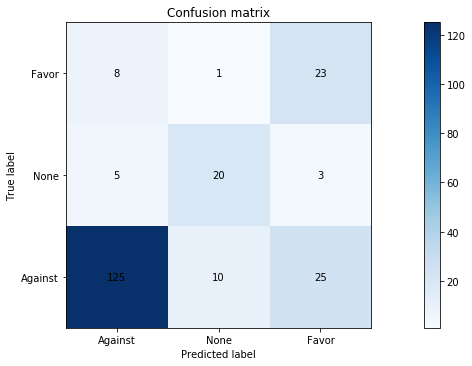

In [68]:
#make predictions and run metrics
test_probs = model.predict(test_data)
metrics(test_y_labels, test_probs)

In [70]:
#store predictions and true labels for calculating overall F score later
ath_tweets = test_tweets
ath_predictions =  np.argmax(test_probs, axis = 1)
ath_labels = test_y_labels

In [71]:
##write predictions to csv files
pd.Series(ath_tweets).to_csv('./final_outputs/atheism_tweets_v3.csv')
pd.Series(ath_predictions).to_csv('./final_outputs/atheism_preds_v3.csv')
pd.Series(ath_labels).to_csv('./final_outputs/atheism_true_v3.csv')

/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing t

## Hillary Clinton

In [85]:
#subset the data
train_tweets, train_data, train_y_array, train_y_labels, dev_tweets, dev_data, dev_y_array, dev_y_labels, test_tweets, test_data, test_y_array, test_y_labels = topic_subset(['Hillary Clinton'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(train_y_labels), train_y_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

#create model instance
model = bert_model_seq(max_length = max_length, 
                       train_layers = 6, 
                       optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                                            beta_1 = 0.9,
                                                            beta_2 = 0.999),
                       dropout_rate = 0.5)

# Instantiate variables
initialize_vars(sess)

#train model
model.fit(
    train_data, 
    train_y_array,
    validation_data = [dev_data, dev_y_array],
    epochs = 20,
    verbose = 1,
    batch_size = 32,
    class_weight = weights)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_8 (BertLayer_Se (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score (Favor and Against only) 0.6447502548419979
              precision    recall  f1-score   support

     Against       0.77      0.70      0.73       172
        None       0.58      0.71      0.64        78
       Favor       0.56      0.56      0.56        45

    accuracy                           0.68       295
   macro avg       0.64      0.65      0.64       295
weighted avg       0.69      0.68      0.68       295



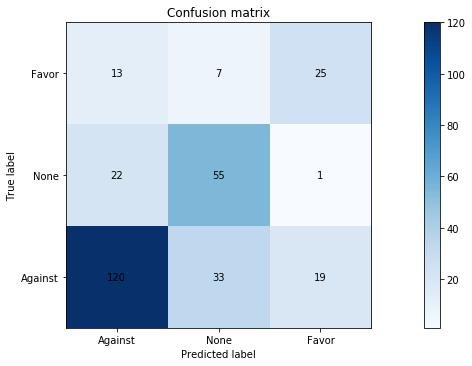

In [86]:
#make predictions and run metrics
test_probs = model.predict(test_data)
metrics(test_y_labels, test_probs)

In [87]:
#store predictions and true labels for calculating overall F score later
hil_tweets = test_tweets
hil_predictions =  np.argmax(test_probs, axis = 1)
hil_labels = test_y_labels

In [132]:
##write predictions to csv files
pd.Series(hil_tweets).to_csv('./final_outputs/hil_tweets_v3.csv')
pd.Series(hil_predictions).to_csv('./final_outputs/hil_preds_v3.csv')
pd.Series(hil_labels).to_csv('./final_outputs/hil_true_v3.csv')

/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing t

## Abortion

In [72]:
#subset the data
train_tweets, train_data, train_y_array, train_y_labels, dev_tweets, dev_data, dev_y_array, dev_y_labels, test_tweets, test_data, test_y_array, test_y_labels = topic_subset(['Legalization of Abortion'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(train_y_labels), train_y_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

#create model instance
model = bert_model_seq(max_length = max_length, 
                       train_layers = 6, 
                       optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                                            beta_1 = 0.9,
                                                            beta_2 = 0.999),
                       dropout_rate = 0.5)

# Instantiate variables
initialize_vars(sess)

#train the model
model.fit(
    train_data, 
    train_y_array,
    validation_data = [dev_data, dev_y_array],
    epochs = 20,
    verbose = 1,
    batch_size = 32,
    class_weight = weights)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_5 (BertLayer_Se (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score (Favor and Against only) 0.640554096011464
              precision    recall  f1-score   support

     Against       0.87      0.58      0.70       189
        None       0.40      0.82      0.54        45
       Favor       0.52      0.67      0.58        46

    accuracy                           0.64       280
   macro avg       0.59      0.69      0.61       280
weighted avg       0.73      0.64      0.65       280



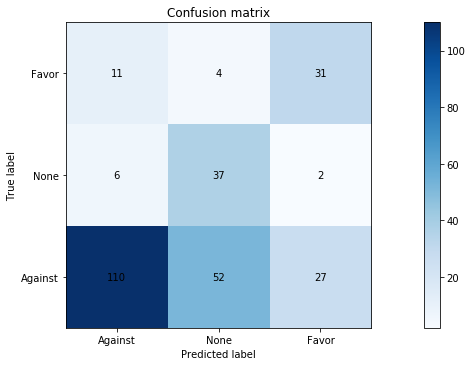

In [73]:
#make predictions and run metrics
test_probs = model.predict(test_data)
metrics(test_y_labels, test_probs)

In [74]:
#store predictions and true labels for calculating overall F score later
abort_tweets = test_tweets
abort_predictions =  np.argmax(test_probs, axis = 1)
abort_labels = test_y_labels

In [75]:
##write predictions to csv files
pd.Series(abort_tweets).to_csv('./final_outputs/abort_tweets_v3.csv')
pd.Series(abort_predictions).to_csv('./final_outputs/abort_preds_v3.csv')
pd.Series(abort_labels).to_csv('./final_outputs/abort_true_v3.csv')

/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing t

## Climate Change

In [22]:
# subset the data
train_tweets, train_data, train_y_array, train_y_labels, dev_tweets, dev_data, dev_y_array, dev_y_labels, test_tweets, test_data, test_y_array, test_y_labels = topic_subset(['Climate Change is a Real Concern'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(train_y_labels), train_y_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

#create model instance
model = bert_model_seq(max_length = max_length, 
                       train_layers = 6, 
                       optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                                            beta_1 = 0.9,
                                                            beta_2 = 0.999),
                       dropout_rate = 0.5)

# Instantiate variables
initialize_vars(sess)

#train model
model.fit(
    train_data, 
    train_y_array,
    validation_data = [dev_data, dev_y_array],
    epochs = 7,
    verbose = 1,
    batch_size = 32,
    class_weight = weights)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_1 (BertLayer_Se (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score (Favor and Against only) 0.4847222222222223
              precision    recall  f1-score   support

     Against       0.20      0.09      0.13        11
        None       0.53      0.26      0.35        35
       Favor       0.78      0.93      0.84       123

   micro avg       0.73      0.73      0.73       169
   macro avg       0.50      0.42      0.44       169
weighted avg       0.69      0.73      0.69       169



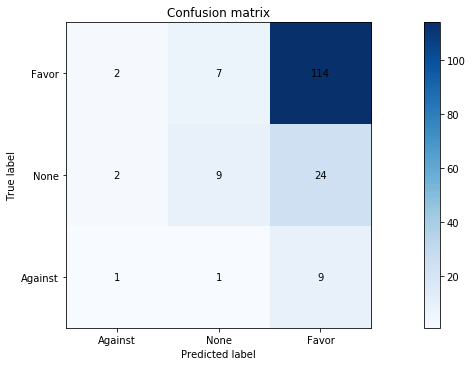

In [23]:
#make predictions and run metrics
test_probs = model.predict(test_data)
metrics(test_y_labels, test_probs)

In [24]:
#store predictions and true labels for calculating overall F score later
clim_tweets = test_tweets
clim_predictions =  np.argmax(test_probs, axis = 1)
clim_labels = test_y_labels

In [38]:
##write predictions to csv files
pd.Series(clim_tweets).to_csv('./final_outputs/clim_tweets_v3.csv')
pd.Series(np.reshape(clim_predictions,(clim_predictions.shape[0],))).to_csv('./final_outputs/clim_preds_v3.csv')
pd.Series(np.reshape(clim_labels,(clim_labels.shape[0],))).to_csv('./final_outputs/clim_true_v3.csv')

/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after r

## Feminism

In [80]:
# subset the data
train_tweets, train_data, train_y_array, train_y_labels, dev_tweets, dev_data, dev_y_array, dev_y_labels, test_tweets, test_data, test_y_array, test_y_labels = topic_subset(['Feminist Movement'])

#Start session
compute_class = compute_class_weight('balanced', np.unique(train_y_labels), train_y_labels)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}

sess = tf.Session()

#create model instance
model = bert_model_seq(max_length = max_length, 
                       train_layers = 6, 
                       optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                                            beta_1 = 0.9,
                                                            beta_2 = 0.999),
                       dropout_rate = 0.5)

# Instantiate variables
initialize_vars(sess)

#train model
model.fit(
    train_data, 
    train_y_array,
    validation_data = [dev_data, dev_y_array],
    epochs = 20,
    verbose = 1,
    batch_size = 32,
    class_weight = weights)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer__seq_7 (BertLayer_Se (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

F1 macro score (Favor and Against only) 0.5775720618127494
              precision    recall  f1-score   support

     Against       0.77      0.69      0.73       183
        None       0.47      0.64      0.54        44
       Favor       0.42      0.43      0.43        58

    accuracy                           0.63       285
   macro avg       0.55      0.59      0.56       285
weighted avg       0.65      0.63      0.64       285



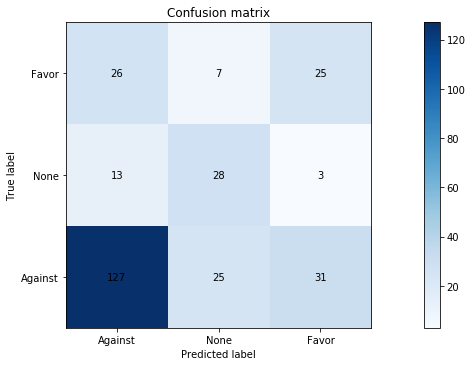

In [81]:
#make predictions and run metrics
test_probs = model.predict(test_data)
metrics(test_y_labels, test_probs)

In [83]:
#store predictions and true labels for calculating overall F score later
fem_tweets = test_tweets
fem_predictions =  np.argmax(test_probs, axis = 1)
fem_labels = test_y_labels

In [84]:
##write predictions to csv files
pd.Series(fem_tweets).to_csv('./final_outputs/fem_tweets_v3.csv')
pd.Series(fem_predictions).to_csv('./final_outputs/fem_preds_v3.csv')
pd.Series(fem_labels).to_csv('./final_outputs/fem_true_v3.csv')

/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/timspittle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing t

## Overall Performance

F1 macro score (Favor and Against only) 0.6971588740348311
              precision    recall  f1-score   support

     Against       0.82      0.68      0.74       715
        None       0.50      0.65      0.57       230
       Favor       0.60      0.72      0.65       304

   micro avg       0.68      0.68      0.68      1249
   macro avg       0.64      0.68      0.65      1249
weighted avg       0.71      0.68      0.69      1249



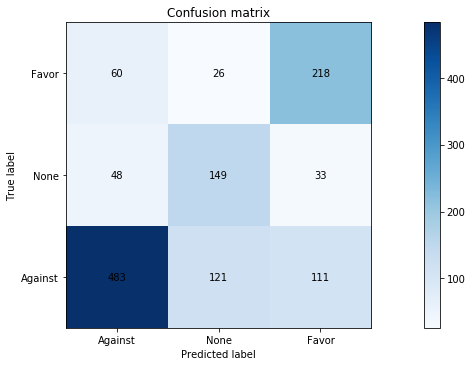

In [39]:
#read in predictions
ath_predictions = pd.read_csv('final_outputs/atheism_preds_v3.csv',header = None, index_col = 0).values
hil_predictions = pd.read_csv('final_outputs/hil_preds_v3.csv', header = None, index_col = 0).values
abort_predictions = pd.read_csv('final_outputs/abort_preds_v3.csv',header = None, index_col = 0).values
clim_predictions = pd.read_csv('final_outputs/clim_preds_v3.csv', header = None, index_col = 0).values
fem_predictions = pd.read_csv('final_outputs/fem_preds_v3.csv', header = None, index_col = 0).values

#read in true labels
ath_labels = pd.read_csv('final_outputs/atheism_true_v3.csv',header = None, index_col = 0).values
hil_labels = pd.read_csv('final_outputs/hil_true_v3.csv', header = None, index_col = 0).values
abort_labels = pd.read_csv('final_outputs/abort_true_v3.csv',header = None, index_col = 0).values
clim_labels = pd.read_csv('final_outputs/clim_true_v3.csv', header = None, index_col = 0).values
fem_labels = pd.read_csv('final_outputs/fem_true_v3.csv', header = None, index_col = 0).values

#stack and reshape
all_preds = np.vstack((ath_predictions, hil_predictions, abort_predictions, clim_predictions, fem_predictions))
all_preds = np.reshape(all_preds, (all_preds.shape[0],))

all_labels = np.vstack((ath_labels, hil_labels, abort_labels, clim_labels, fem_labels))
all_labels = np.reshape(all_labels, (all_labels.shape[0],))

#metrics
#calculate f1 score and print classification report
class_report = classification_report(y_true = all_labels, 
                                        y_pred = all_preds,
                                        target_names = ['Against', 'None', 'Favor'], output_dict=True)
    
print("F1 macro score (Favor and Against only)", str((class_report['Favor']['f1-score'] + 
         class_report['Against']['f1-score']) / 2))
    
print(classification_report(y_true = all_labels, 
                                        y_pred = all_preds,
                                        target_names = ['Against', 'None', 'Favor']))
    
confuse = confusion_matrix(y_true = all_labels, y_pred = all_preds)
    
plt.figure(figsize=(15, 5))
confusion_plot(confuse, ['Against', 'None', 'Favor'])
plt.show()